In [27]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from skimage.morphology import skeletonize
from skimage import data
import sknw
import cv2
from scipy import ndimage as ndi
from skimage.morphology import watershed
from tqdm import tqdm_notebook
from scipy.spatial.distance import cdist
import geopandas as gpd
from shapely.geometry import LineString

%matplotlib inline

In [2]:
def save_gpd_df(save_path, geom_df, meta=None):
    if meta:
        geom_df.crs = meta.get('crs')
    if os.path.exists(save_path):
        os.remove(save_path)
    geom_df.to_file(save_path, driver='GeoJSON', encoding='utf-8')

In [24]:
def sort_points_recur(graph_ps_x):
    input_shape = graph_ps_x.shape
    graph_index = 0
    sorted_graph_pts = [graph_ps_x[graph_index]]
    
    for i in range(len(graph_ps_x)):
        #point = 
        graph_ps_x = np.delete(graph_ps_x, graph_index, axis=0)
        dist_end = cdist(np.expand_dims(sorted_graph_pts[i], axis=0), graph_ps_x)
        dist_start = cdist(np.expand_dims(sorted_graph_pts[0], axis=0), graph_ps_x)
        #print(dists.shape)
        if len(dist_end[0]) > 0:
            graph_min_val_end = np.min(dist_end)
            graph_min_val_start = np.min(dist_start)
            if graph_min_val_end > graph_min_val_start:
                graph_index = np.argmin(dist_start)
                sorted_graph_pts.insert(0, graph_ps_x[graph_index])
                # sorted_graph_pts.append(graph_ps_x[graph_index])
            else:
                graph_index = np.argmin(dist_end)
                sorted_graph_pts.append(graph_ps_x[graph_index])
    sorted_graph_pts = np.array(sorted_graph_pts)
    #print(sorted_graph_pts.shape, input_shape)
    assert input_shape == sorted_graph_pts.shape
    return sorted_graph_pts

In [4]:
def my_watershed(energy, markers, mask):
    """
    Watershed wrapper.

    :param energy: Watershed "energy" mask
    :param markers: "kernels" for the watershed algorithm
    :param mask: Binary mask separating a single class
    :return: Image with every instance labeled with a separate number.
    """
    markers = ndi.label(markers, output=np.uint32)[0]
    labels = watershed(255-energy, markers, watershed_line=True, mask=mask)
    return labels

In [35]:
raster_path = "/mnt/storage_4tb/ymi/geo_data/angle_net_data/job_results/fixed/1-68/dist_net_resnet_1349_256_aug_lines/project_transparent_mosaic_rgb_bin.tif"
downscale = 0.2
with rasterio.open(raster_path, "r") as src:
    image = src.read(2)
    #
    meta = src.meta
    kernel_size = int(1 / meta['transform'][0])
    if (kernel_size % 2) == 0:
        kernel_size += 1
#     tree_line_mask = cv2.resize(image[0], None, fx=0.2, fy=0.2, interpolation=cv2.INTER_NEAREST)
#     gap_line_mask = cv2.resize(image[1], None, fx=0.2, fy=0.2, interpolation=cv2.INTER_NEAREST)
        tree_line_mask = cv2.resize(image, None, fx=downscale, fy=downscale, interpolation=cv2.INTER_NEAREST)

    mask = tree_line_mask > 200
    markers = tree_line_mask > 200
    energy = tree_line_mask.copy()
    energy[energy < 200] = 0
    labels = my_watershed(energy, markers, mask)
    #lines = prepare_lines_masks(image, downscale=0.2, kernel_size=(kernel_size, kernel_size))

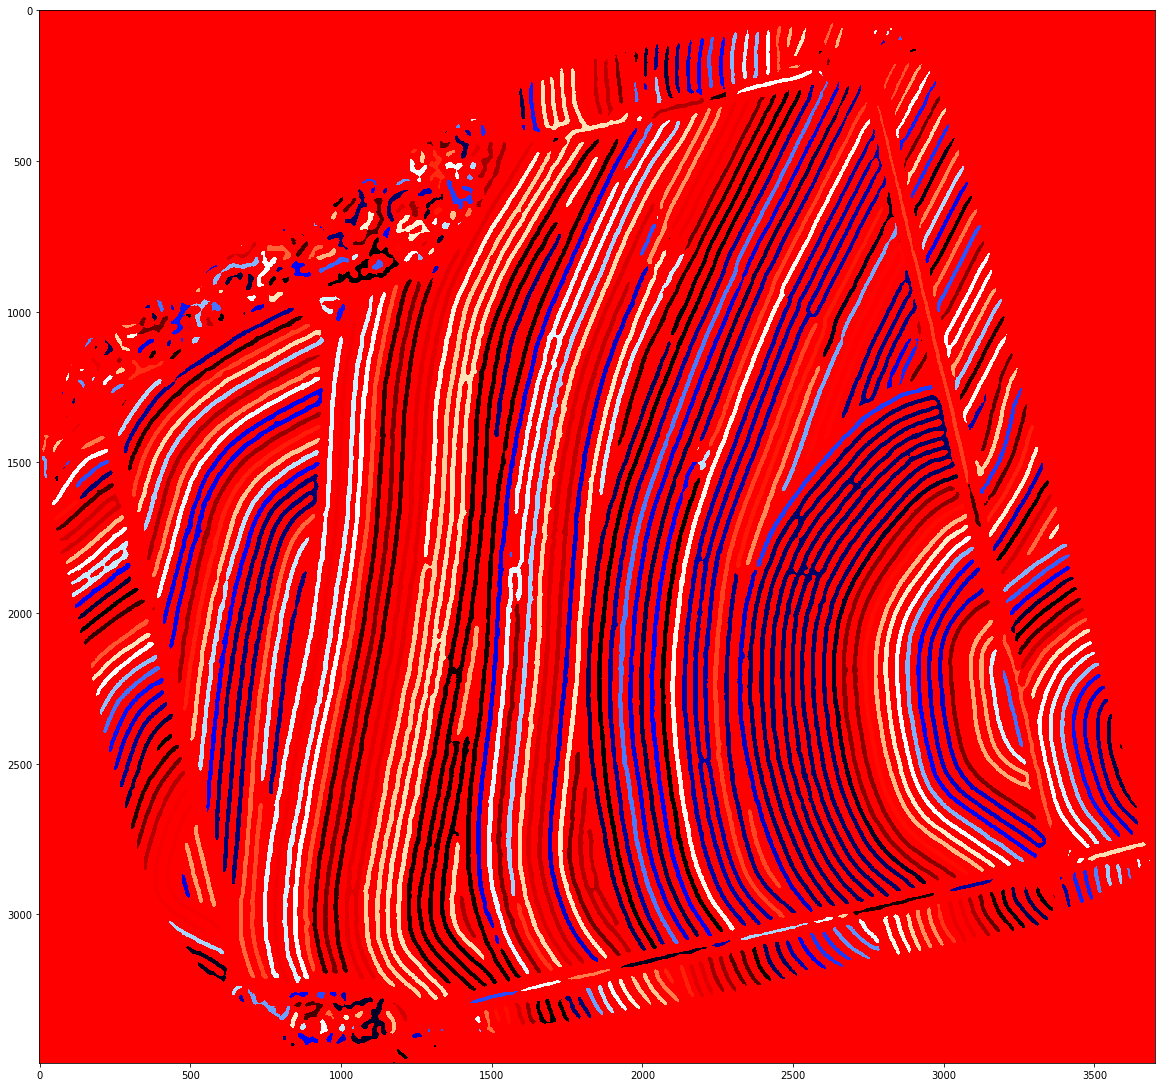

In [36]:
plt.figure(figsize=(20,20))
plt.imshow(labels, 'flag')

In [37]:
def make_lines(labels):
    graphs = []       
    for num, label in tqdm_notebook(enumerate(range(1, len(np.unique(labels)) + 1)), total=len(np.unique(labels))):
        label_mask = labels == label
        ske = skeletonize(label_mask).astype(np.uint16)
        graph = sknw.build_sknw(ske)
        graphs.append(graph)
        
#         if num == 100:
#             break
    return graphs

In [ ]:
def prepare_lines_masks(image, downscale=0.2, kernel_size=(13, 13)):
    lines = (image[1] > 220) | (image[0] > 150)
    kernel = np.ones(kernel_size)
    blur = cv2.GaussianBlur(lines.astype(np.uint8),kernel_size,0)
    lines = cv2.dilate(blur.astype(np.uint8), kernel_size)
    lines = cv2.morphologyEx(lines, cv2.MORPH_CLOSE, kernel)
    tree_line_mask = cv2.resize(lines, None, fx=downscale, fy=downscale, interpolation=cv2.INTER_NEAREST)
    return tree_line_mask

In [ ]:
#gap_line_mask
# lines = gap_line_mask / 255 + tree_line_mask / 255
# lines[lines > 1] = 1
# lines = (lines * 255).astype(np.uint8)
#lines = lines > 220
lines = (gap_line_mask > 220) | (tree_line_mask > 150)
kernel = np.ones((3,3))
blur = cv2.GaussianBlur(lines.astype(np.uint8),(3,3),0)
lines = cv2.dilate(blur.astype(np.uint8), (3,3))
lines = cv2.morphologyEx(lines, cv2.MORPH_CLOSE, kernel)

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(ridges, 'gray')

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(lines, 'gray')

In [ ]:
lines.max()

In [ ]:
lines = (lines * 255).astype(np.uint8)

In [ ]:
mask = lines > 220
markers = lines > 220
energy = lines.copy()
#energy[energy < 150] = 0
labels = my_watershed(energy, markers, mask)
# labels = my_watershed(lines, lines, lines)

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(labels, 'flag')

In [38]:
graph_lines = make_lines(labels)

In [121]:
test_each = np.arange(50)
last = test_each[-1]
test_each = test_each[::10]
test_each = np.append(test_each, last)
print(test_each)

[ 0 10 20 30 40 49]


In [131]:
lines = []
each = 20
for num, graph in tqdm_notebook(enumerate(graph_lines)):
#     node, nodes = graph.node, graph.nodes()
#     ps = np.array([node[i]['o'] for i in nodes])
    same_row = []
    node, nodes = graph.node, graph.nodes()
    #endpts = np.array([node[i]['o'] for i in nodes])
    #print(endpts)
    for (s,e) in graph.edges():
        ps = []
        weight = graph[s][e]['weight']
        if weight < 50:
            continue
        ps.append(nodes[s]['o'])
        pts = graph[s][e]['pts']
        ps.extend(pts)
        ps.append(nodes[e]['o'])
        ps = np.array(ps)
        #print(len(ps))
        if len(ps) > each:
            last = np.expand_dims(ps[-1], axis=0)
            #print(last)
            ps = ps[::each]
            ps = np.append(ps, last, axis=0)
            # print(ps.shape)
        if len(ps) < 2:
            continue
        ps =  ps * 1 / 0.2
        # change x and y
        ps_yx = ps.copy()
        ps_yx[:, 1] = ps[:, 0]
        ps_yx[:, 0] = ps[:, 1]
        #
        converted = [meta['transform'] * pt for pt in ps_yx]
        line = LineString(converted)
        lines.append(line)

    

In [140]:
def get_polygons_in_window(dataframe, window):
    filtered = dataframe.geometry.apply(lambda p: window.intersects(p))
    filtered = gpd.GeoDataFrame(filtered)
    filtered = filtered.loc[(filtered['geometry'] == True)]
    merged_DB = dataframe.join(filtered.drop(columns=['geometry']), how="inner")
    return merged_DB

In [171]:
from shapely.geometry import Polygon, MultiPoint
import math

In [167]:
def df_wgs_to_utm(gdf):
    if (gdf.crs["init"]!="epsg:4326"):
        raise Exception("in df_wgs_to_utm - converting GeoDataFrame projection from wgs to utm - input GeoDataFrame is not in wgs. crs is {}".format(gdf.crs))
    points = gdf.geometry.centroid.tolist()
    multi = MultiPoint(points)
    pt = multi.centroid.coords[0]
    epsg = convert_wgs_to_utm(pt[0],pt[1])
    return gdf.to_crs({'init': 'epsg:' + epsg})

def convert_wgs_to_utm(lon, lat):
    utm_band = str((math.floor((lon + 180) / 6 ) % 60) + 1)
    if len(utm_band) == 1:
        utm_band = '0'+utm_band
    if lat >= 0:
        epsg_code = '326' + utm_band
    else:
        epsg_code = '327' + utm_band
    return epsg_code

In [187]:
line_dataframe = gpd.read_file("/mnt/storage_4tb/ymi/tmp/bugs/1-37/detected_rows.geojson")
line_dataframe = df_wgs_to_utm(line_dataframe)
lines =line_dataframe['geometry'].values.tolist()
for line in lines:
    if not line.is_simple:
        print(True)

In [188]:
line_dataframe = gpd.read_file("/mnt/storage_4tb/ymi/tmp/bugs/1-37/detected_rows.geojson")
line_dataframe = df_wgs_to_utm(line_dataframe)
lines =line_dataframe['geometry'].values.tolist()
line_polys = []
for line in lines:
    
    line_polys.append(line.buffer(0.1))
poly_df = gpd.GeoDataFrame(geometry=line_polys)

for poly, line in zip(line_polys, lines):
    intersected_dataframe = get_polygons_in_window(line_dataframe, line)
    #print(len(intersected_dataframe))
    if len(intersected_dataframe) > 1:
        print(len(intersected_dataframe))
        inter_list = intersected_dataframe['geometry'].values.tolist()
        for poly in inter_list:
            det_intersection = poly.intersection(inter_list[0])
            if abs(det_intersection.area - poly.area) > 0.1:
                print(det_intersection.area)
        #break

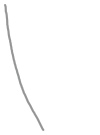

In [178]:
intersected_dataframe['geometry'].values.tolist()[0]

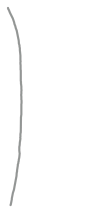

In [179]:
intersected_dataframe['geometry'].values.tolist()[1]

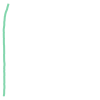

In [160]:
lines[1]

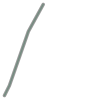

In [139]:
line_polys[0]

In [106]:
def graph_to_shp_lines(graph_lines, meta, each=20, downscale=0.2):
    lines = []
    for graph in tqdm_notebook(graph_lines, len(lines)):

        node, nodes = graph.node, graph.nodes()
        graph_ps = []
        for (s, e) in graph.edges():
            ps = []
            weight = graph[s][e]['weight']
            if weight < 50:
                continue
            ps.append(nodes[s]['o'])
            pts = graph[s][e]['pts']
            ps.extend(pts)
            ps.append(nodes[e]['o'])
            ps = np.array(ps)
            # print(len(ps))
            if len(ps) > each:
                ps = ps[::each]
            graph_ps.extend(ps)
        graph_ps = np.array(graph_ps)
        if len(graph_ps) < 2:
            continue

        # sort points in one line
        y_axis_var = np.var(graph_ps[:, 1])
        x_axis_var = np.var(graph_ps[:, 0])
        if y_axis_var > x_axis_var:
            ind = np.lexsort((graph_ps[:, 0], graph_ps[:, 1]))
        else:
            ind = np.lexsort((graph_ps[:, 1], graph_ps[:, 0]))
        all_coords = graph_ps[ind]

        # sort points recursively
        graph_ps = sort_points_recur(all_coords)

        # transform points to world coordinates
        graph_ps = graph_ps * 1 / downscale
        ps_yx = graph_ps.copy()
        ps_yx[:, 1] = graph_ps[:, 0]
        ps_yx[:, 0] = graph_ps[:, 1]
        converted = [meta['transform'] * pt for pt in ps_yx]

        line = LineString(converted)
        lines.append(line)
    return lines

In [107]:
shp_lines = graph_to_shp_lines(graph_lines, meta, each=20, downscale=0.2)

In [43]:
graph_lines[0]

[(0, 2), (1, 2), (2, 3), (3, 4), (3, 5)]
1.0
5.414213562373095
5.414213562373095
8.485281374238571
16.48528137423857
[[973.   583.  ]
 [975.   574.  ]
 [977.   581.75]
 [985.75 584.  ]
 [993.   575.  ]
 [996.   598.  ]]


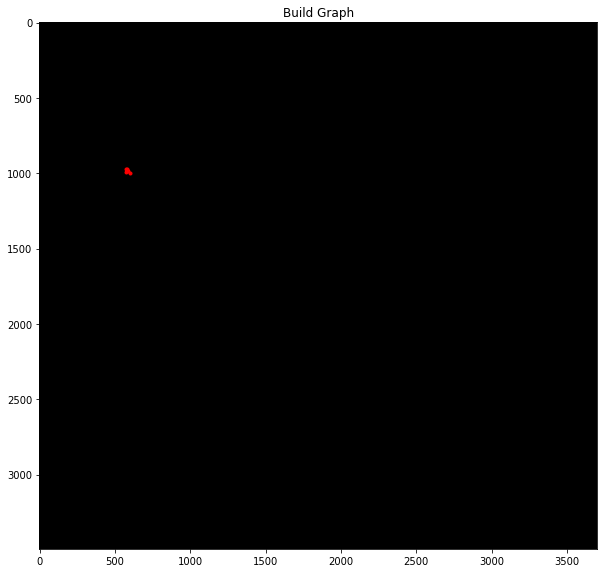

In [102]:
img = labels == 211
ske = skeletonize(img).astype(np.uint16)

# build graph from skeleton
graph = sknw.build_sknw(ske)
plt.figure(figsize=(10, 10))
# draw image
plt.imshow(img, cmap='gray')
print(graph.edges())
# draw edges by pts
for (s,e) in graph.edges():
    ps = graph[s][e]['pts']
    weight = graph[s][e]['weight']
    print(weight)
    plt.plot(ps[:,1], ps[:,0], 'green')
new_ps = ps.copy()
# draw node by o
node, nodes = graph.node, graph.nodes()
ps = np.array([node[i]['o'] for i in nodes])
plt.plot(ps[:,1], ps[:,0], 'r.')
print(ps)
# title and show
plt.title('Build Graph')
plt.show()

In [ ]:
lines = []
each = 50
for graph in tqdm_notebook(graph_lines, len(lines)):
#     node, nodes = graph.node, graph.nodes()
#     ps = np.array([node[i]['o'] for i in nodes])
    
    node, nodes = graph.node, graph.nodes()
    graph_ps = []
    for (s,e) in graph.edges():
        ps = []
        weight = graph[s][e]['weight']
        if weight < 10:
            continue
        ps.append(nodes[s]['o'])
        pts = graph[s][e]['pts']
        ps.extend(pts)
        ps.append(nodes[e]['o'])
        ps = np.array(ps)
        #print(len(ps))
        if len(ps) > each:
            ps = ps[::each]
        graph_ps.extend(ps)
    graph_ps = np.array(graph_ps)
    if len(graph_ps) < 2:
        continue
    #print(graph_ps.shape)
    #print(np.unique(graph_ps))
    y_axis_var = np.var(graph_ps[:,1])
    x_axis_var = np.var(graph_ps[:,0])
    if y_axis_var > x_axis_var:
    #print(y_axis_var, x_axis_var)
        ind = np.lexsort((graph_ps[:,0],graph_ps[:,1]))
    else:
        ind = np.lexsort((graph_ps[:,1],graph_ps[:,0]))
    all_coords = graph_ps[ind]
    graph_ps = sort_points_recur(all_coords)
    #print(np.unique(graph_ps))
    #print(graph_ps.shape)
    graph_ps =  graph_ps * 1 / 0.2
    # change x and y
    ps_yx = graph_ps.copy()
    ps_yx[:, 1] = graph_ps[:, 0]
    ps_yx[:, 0] = graph_ps[:, 1]
    #
    converted = [meta['transform'] * pt for pt in ps_yx]
#     for pt in converted:
#         lines.append(Point(pt))
    line = LineString(converted)
    lines.append(line)

In [132]:
save_path = "/mnt/storage_4tb/ymi/geo_data/angle_net_data/job_results/1-68/dist_net_resnet_1349_256_aug_lines/detected_lines_no_merge.geojson"
line_gdf = gpd.GeoDataFrame(geometry=lines)
save_gpd_df(save_path, line_gdf, meta=meta)

In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(tree_line_mask, 'gray')